# Entangled Learning with Jensen-Shannon Divergence
This notebook demonstrates **Entangled Learning 3.0**, where one CNN teacher and two weak MLP student models are trained collaboratively via output alignment using **Jensen-Shannon (JS) divergence**.

### Goals:
- Use a CNN as a strong teacher
- Train two weak MLPs on PCA-compressed inputs
- Encourage output similarity via JS Divergence (soft alignment)
- Enable MLP-to-MLP mutual learning
- Gradually transition from soft alignment (JS) to hard label imitation


## 1. Imports and Setup
Here we import TensorFlow, sklearn utilities, and define JS divergence.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from sklearn.metrics import roc_auc_score

# JS Divergence
def jensen_shannon(p_logits, q_logits):
    p = tf.nn.softmax(p_logits)
    q = tf.nn.softmax(q_logits)
    m = 0.5 * (p + q)
    kl_pm = tf.reduce_sum(p * tf.math.log(tf.clip_by_value(p / m, 1e-7, 1e7)), axis=1)
    kl_qm = tf.reduce_sum(q * tf.math.log(tf.clip_by_value(q / m, 1e-7, 1e7)), axis=1)
    return tf.reduce_mean(0.5 * (kl_pm + kl_qm))

## 2. Data Preparation (CIFAR-10)
We normalize the images, convert labels to one-hot, and apply two independent PCA compressions for each student MLP model (simulating different views of the same input).

In [ ]:
# Veri: CIFAR10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train_cat = tf.keras.utils.to_categorical(y_train, 10)
y_test_cat = tf.keras.utils.to_categorical(y_test, 10)

# PCA hazırlık
x_train_flat = x_train.reshape(len(x_train), -1)
x_test_flat = x_test.reshape(len(x_test), -1)

# Her MLP için farklı seed ve PCA
np.random.seed(42)
pca_B = PCA(n_components=100, random_state=42)
x_train_pca_B = pca_B.fit_transform(x_train_flat)
x_test_pca_B = pca_B.transform(x_test_flat)
x_train_pca_B = StandardScaler().fit_transform(x_train_pca_B)
x_test_pca_B = StandardScaler().fit_transform(x_test_pca_B)

np.random.seed(123)
pca_C = PCA(n_components=100, random_state=123)
x_train_pca_C = pca_C.fit_transform(x_train_flat)
x_test_pca_C = pca_C.transform(x_test_flat)
x_train_pca_C = StandardScaler().fit_transform(x_train_pca_C)
x_test_pca_C = StandardScaler().fit_transform(x_test_pca_C)

## 3. Model Definitions
- CNN as the teacher (Model A)
- Two small MLPs as students (Model B and C)
- BatchNorm and Dropout included to mitigate overfitting

In [ ]:
def make_cnn():
    inp = Input(shape=(32, 32, 3))
    x = Conv2D(32, 3, activation='relu')(inp)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    out = Dense(10)(x)
    return Model(inp, out)

def make_mlp_small_B():
    return Sequential([
        Input(shape=(100,)),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(10)
    ])

def make_mlp_small_C():
    return Sequential([
        Input(shape=(100,)),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(10)
    ])

model_A = make_cnn()
model_B = make_mlp_small_B()
model_C = make_mlp_small_C()

opt_A = tf.keras.optimizers.Adam(learning_rate=0.0005)
opt_B = tf.keras.optimizers.Adam(learning_rate=0.0005)
opt_C = tf.keras.optimizers.Adam(learning_rate=0.0005)

## 4. Loss Functions
- `hybrid_js_label_loss`: JS-based alignment initially, transitions to label imitation
- `mutual_js_loss`: Soft mutual learning between students

In [ ]:
def hybrid_js_label_loss(y_true, logits_student, logits_teacher, λ_js, epoch, js_to_label_epoch=20):
    ce_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    if epoch < js_to_label_epoch:
        js = jensen_shannon(logits_student, tf.stop_gradient(logits_teacher))
        return ce_loss(y_true, logits_student) + λ_js * js
    else:
        teacher_labels = tf.argmax(logits_teacher, axis=1)
        student_labels = tf.argmax(logits_student, axis=1)
        label_loss = tf.reduce_mean(tf.cast(tf.not_equal(teacher_labels, student_labels), tf.float32))
        return ce_loss(y_true, logits_student) + λ_js * label_loss

def mutual_js_loss(logits_B, logits_C, λ_js, epoch, js_to_label_epoch=20):
    if epoch < js_to_label_epoch:
        return λ_js * jensen_shannon(logits_B, tf.stop_gradient(logits_C)) + \
               λ_js * jensen_shannon(logits_C, tf.stop_gradient(logits_B))
    else:
        labels_B = tf.argmax(logits_B, axis=1)
        labels_C = tf.argmax(logits_C, axis=1)
        label_loss = tf.reduce_mean(tf.cast(tf.not_equal(labels_B, labels_C), tf.float32))
        return λ_js * label_loss

## 5. Training Loop
- `λ_js` increases slowly (logarithmically)
- All 3 models are trained simultaneously
- Metrics recorded at each epoch: Loss, Accuracy, ROC-AUC

In [ ]:
epochs = 30
batch_size = 128

loss_log_A, loss_log_B, loss_log_C = [], [], []
acc_log_A, acc_log_B, acc_log_C = [], [], []
roc_log_A, roc_log_B, roc_log_C = [], [], []
lambda_log = []

for epoch in range(epochs):
    λ_js = 0.1 * np.log10(1 + 9 * (epoch / (epochs - 1)))  # Daha yavaş artış, max 0.1
    lambda_log.append(λ_js)
    print(f"Epoch {epoch+1}/{epochs} | λ = {λ_js:.4f}")

    idx = np.random.permutation(len(x_train))
    x_train_shuffled = x_train[idx]
    x_pca_B_shuffled = x_train_pca_B[idx]
    x_pca_C_shuffled = x_train_pca_C[idx]
    y_shuffled = y_train_cat[idx]

    losses_A, losses_B, losses_C = [], [], []

    for i in range(0, len(x_train), batch_size):
        xb_cnn = x_train_shuffled[i:i+batch_size]
        xb_pca_B = x_pca_B_shuffled[i:i+batch_size]
        xb_pca_C = x_pca_C_shuffled[i:i+batch_size]
        yb = y_shuffled[i:i+batch_size]

        with tf.GradientTape(persistent=True) as tape:
            logits_A = model_A(xb_cnn, training=True)
            logits_B = model_B(xb_pca_B, training=True)
            logits_C = model_C(xb_pca_C, training=True)

            loss_A = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(yb, logits_A)
            loss_B = hybrid_js_label_loss(yb, logits_B, logits_A, λ_js, epoch)
            loss_C = hybrid_js_label_loss(yb, logits_C, logits_A, λ_js, epoch)
            mutual_loss = mutual_js_loss(logits_B, logits_C, λ_js, epoch)
            loss_B += mutual_loss
            loss_C += mutual_loss

        grads_A = tape.gradient(loss_A, model_A.trainable_variables)
        grads_B = tape.gradient(loss_B, model_B.trainable_variables)
        grads_C = tape.gradient(loss_C, model_C.trainable_variables)

        opt_A.apply_gradients(zip(grads_A, model_A.trainable_variables))
        opt_B.apply_gradients(zip(grads_B, model_B.trainable_variables))
        opt_C.apply_gradients(zip(grads_C, model_C.trainable_variables))

        losses_A.append(loss_A.numpy())
        losses_B.append(loss_B.numpy())
        losses_C.append(loss_C.numpy())

    loss_log_A.append(np.mean(losses_A))
    loss_log_B.append(np.mean(losses_B))
    loss_log_C.append(np.mean(losses_C))
    print(f"Losses → A: {loss_log_A[-1]:.4f}, B: {loss_log_B[-1]:.4f}, C: {loss_log_C[-1]:.4f}")

    # Test setinde accuracy ve ROC ölçümü
    logits_A_test = model_A.predict(x_test, verbose=0)
    logits_B_test = model_B.predict(x_test_pca_B, verbose=0)
    logits_C_test = model_C.predict(x_test_pca_C, verbose=0)

    y_true = y_test_cat

    acc_A = np.mean(np.argmax(logits_A_test, axis=1) == np.argmax(y_true, axis=1))
    acc_B = np.mean(np.argmax(logits_B_test, axis=1) == np.argmax(y_true, axis=1))
    acc_C = np.mean(np.argmax(logits_C_test, axis=1) == np.argmax(y_true, axis=1))
    acc_log_A.append(acc_A)
    acc_log_B.append(acc_B)
    acc_log_C.append(acc_C)

    # ROC-AUC (macro average)
    try:
        roc_A = roc_auc_score(y_true, tf.nn.softmax(logits_A_test).numpy(), average='macro', multi_class='ovr')
        roc_B = roc_auc_score(y_true, tf.nn.softmax(logits_B_test).numpy(), average='macro', multi_class='ovr')
        roc_C = roc_auc_score(y_true, tf.nn.softmax(logits_C_test).numpy(), average='macro', multi_class='ovr')
    except Exception:
        roc_A, roc_B, roc_C = 0, 0, 0
    roc_log_A.append(roc_A)
    roc_log_B.append(roc_B)
    roc_log_C.append(roc_C)

    print(f"Test Accuracies → A: {acc_A:.4f}, B: {acc_B:.4f}, C: {acc_C:.4f}")
    print(f"Test ROC-AUC     → A: {roc_A:.4f}, B: {roc_B:.4f}, C: {roc_C:.4f}")

## 6. Evaluation and Visualization
Training results are plotted across 4 subplots:
- Training Loss
- Test Accuracy
- Test ROC-AUC
- λ (entanglement weight) progression

In [ ]:
plt.figure(figsize=(16, 10))
plt.subplot(2,2,1)
plt.plot(loss_log_A, label="CNN (Teacher) Loss")
plt.plot(loss_log_B, label="MLP Small B Loss")
plt.plot(loss_log_C, label="MLP Small C Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(2,2,2)
plt.plot(acc_log_A, label="CNN (Teacher) Accuracy")
plt.plot(acc_log_B, label="MLP Small B Accuracy")
plt.plot(acc_log_C, label="MLP Small C Accuracy")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(2,2,3)
plt.plot(roc_log_A, label="CNN (Teacher) ROC-AUC")
plt.plot(roc_log_B, label="MLP Small B ROC-AUC")
plt.plot(roc_log_C, label="MLP Small C ROC-AUC")
plt.title("Test ROC-AUC")
plt.xlabel("Epoch")
plt.ylabel("ROC-AUC")
plt.grid(True)
plt.legend()

plt.subplot(2,2,4)
plt.plot(lambda_log, label="λ (JS Weight)", linestyle='--', color='gray')
plt.title("Lambda (JS Divergence Weight)")
plt.xlabel("Epoch")
plt.ylabel("Lambda")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


```text
Epoch 1/30 | λ = 0.0000
Losses → A: 1.6146, B: 2.5909, C: 2.6572
Test Accuracies → A: 0.3576, B: 0.3010, C: 0.2232
...
Epoch 30/30 | λ = 0.1000
Losses → A: 0.2218, B: 1.6209, C: 1.7604
Test Accuracies → A: 0.7293, B: 0.5016, C: 0.4625
```

# The image below shows the evaluation metrics obtained after model training:

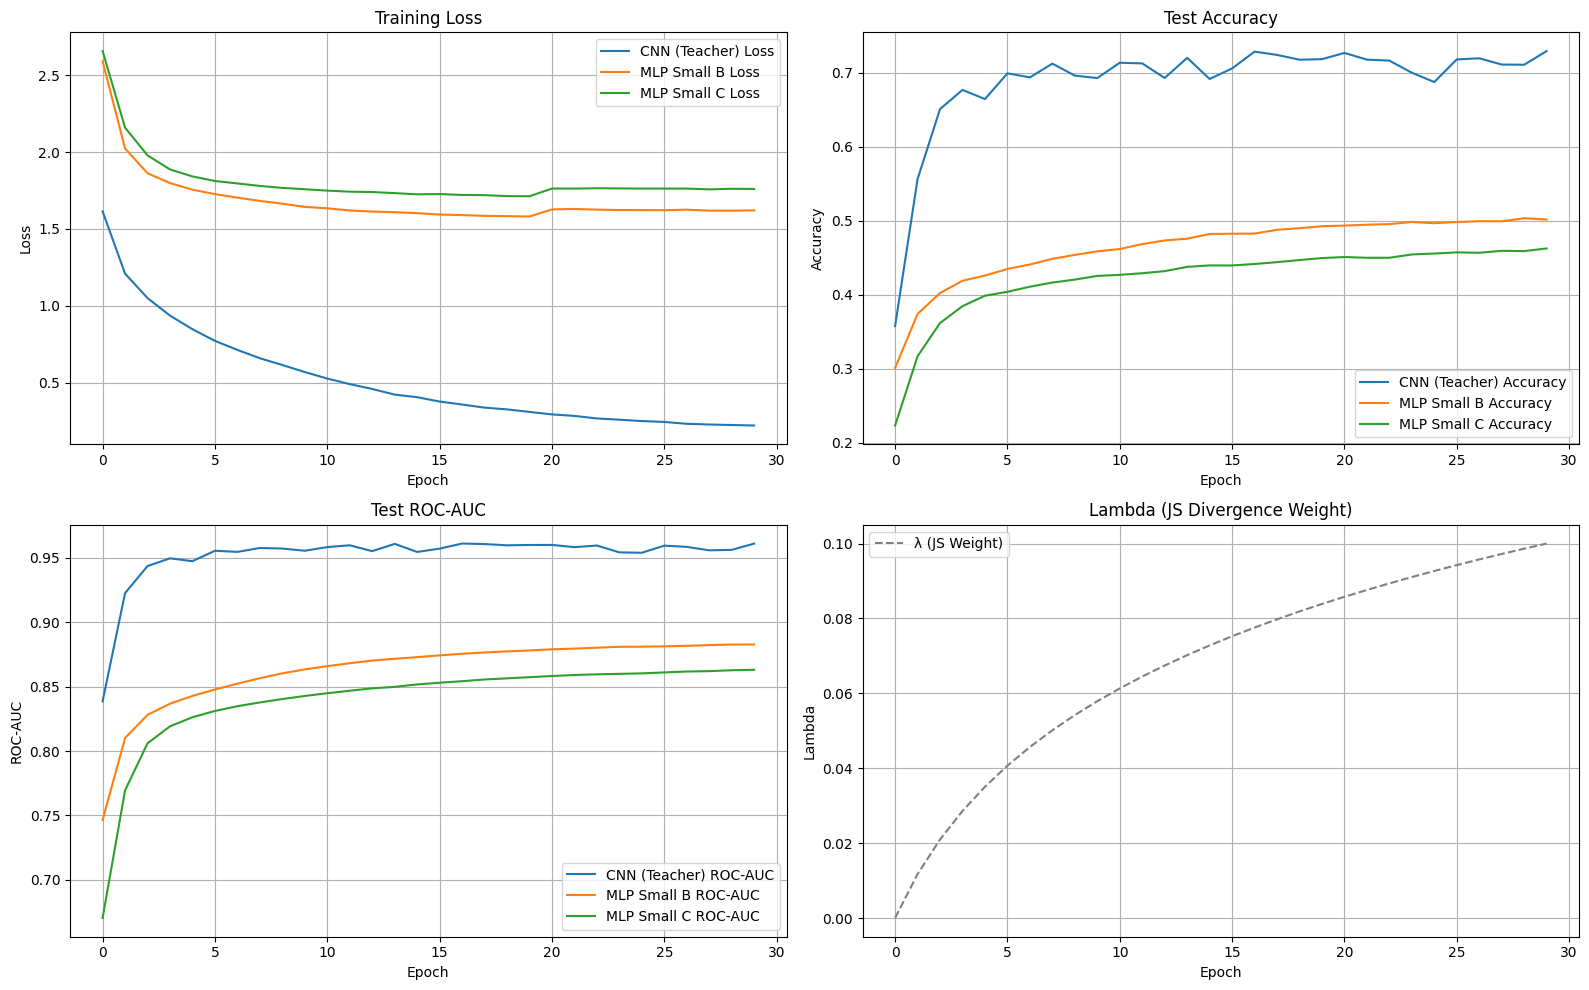